# Einführung in die Neuroinformatik - 7. Aufgabenblatt
## Gruppe Q: Dominik Authaler, Marco Deuscher, Carolin Schindler

### Aufgabe 1: Learning Slowdown

#### 1. Untersuchung von $\frac{\partial E}{\partial b_2}$
##### a) $\frac{\partial E}{\partial b_2}$ mit gegebenen Werten berechnen
$\frac{\partial E}{\partial b_2} = 2 \cdot f(1,5) \cdot f(1,5) \cdot (1-f(1,5)) \approx 0,24$
##### b) $\frac{\partial E}{\partial b_2}$ mit neuen Werten berechnen
$\frac{\partial E}{\partial b_2} = 2 \cdot f(4) \cdot f(4) \cdot (1-f(4)) \approx 0,0347$
##### c) Welches Problem haben wir im letzten Fall und welcher Faktor ist dafür hauptsächlich verantwortlich?
Problem: Gradient sehr klein. D.h. Netzwerk lernt sehr langsam, es dauert also lange bis die Netzwerkausgabe dem Lehrersignal entspricht.  
verantwortlicher Faktor: $f'(u_2)$ mit großem $u_2$

#### 2. zwei lernende Neuronen
##### a) $\frac{\partial E}{\partial b_1}$ berechnen und argumentieren, ob das obige Problem verstärkt oder abgeschwächt wird
$\frac{\partial E}{\partial b_1} = -2\cdot (T-y_2)\cdot f'(u_2)\cdot w_2\cdot f'(u_1)$  
Das Probelm wird verstärkt, da nun $f'(u_i)$ zweimal vorkommt und somit quasi quadratisch eingeht.
##### b) Wie würde sich das Problem bei noch mehr Zwischenschichten weiterentwickeln?
Das Problem würde sich mit jeder weiteren Zwischenschicht verstärken, da mit jeder Schicht in der Ableitung der Fehlerfunktion ein weiterer Faktor $f'(u_i)$ hinzukommt.
##### c) Warum kann sich dadurch die Suche nach einem lokalen Minimum in die Länge ziehen?
Lernvorgang geht sehr langsam voran bis $u_i$ kleiner werden. Je größer also die $u_i$ zu Beginn gewählt wurden, desto länger dauert es bis die Ausgabe dem Lehrersignal entspricht.

#### 3. Untersuchung eines weiteren Problems
##### a) $\frac{\partial E}{\partial b_2}$ und $\frac{\partial E}{\partial b_1}$ mit gegebenen Werten berechnen
$\frac{\partial E}{\partial b_2} = 2 \cdot f(0) \cdot f(0) \cdot (1-f(0)) = 0,25 $  
$\frac{\partial E}{\partial b_1} = 2\cdot f(0) \cdot [f(0) \cdot (1-f(0))]^2 \cdot 100 = 6,25 $
##### b) Wie entwickelt sich die begonnene Folge für noch mehr Zwischenschichten?
$\frac{\partial E}{\partial b_n} = 2\cdot f(0) \cdot [f(0) \cdot (1-f(0))]^n \cdot 100^{n-1} = (0,25)^n \cdot 100^{n-1} = \frac{(25)^n}{100} \rightarrow \infty \text{ für } n \rightarrow \infty$  
mit $n \geq 1$ Schichtnummer von Ausgang ($n=1$) zu Eingang ($n \rightarrow \infty$)
##### c) Was für ein Problem können wir nun beobachten? Warum kann dies die Suche nach einem lokalen Minimum ebenfalls erschweren?
Problem: Gradient sehr groß. D.h. Netzwerk lernt sehr schnell, es kann also passieren, dass lokale Minima (ständig) übersprungen werden.

#### 4. Inwieweit löst die cross entropy-Funktion zumindest zum Teil das hier beschriebene Problem?
$f'(u_i)$ kommt im Gradienten der cross entropy-Funktion einmal weniger vor als im Gradienten der qaudratischen Fehlerunktion. Dadurch treten die obigen Probleme weniger stark auf.


### Aufgabe 2: Flat vs. Deep Networks

#### 1. Untersuchung der Lösung $net_d$
##### a) Netzwerkausgabe für gegebene Eingabe berechnen und überprüfen
$f(x,y) = 0$  
$f((0,0), (1,1)) =(\sum_{i=1}^2 x_i\cdot y_i)\mod 2 = (0\cdot 1 + 0\cdot 1)\mod 2 = 0\mod 2 = 0$
##### b) Netzwerk für $n=3$ erweitern
Pfeile ohne Zahl sind mit $1$ gewichtet
<img src="Blatt07_Bild21b.png"> 
##### c) Welche Rolle kommt den Neuronen in der 1. und 2. Zwischenschicht jeweils zu? Welche Art Zwischenergebnis berechnen sie?
Neuronen in der 1. Zwischenschicht berechenen jeweils für ein festes $i$: $x_i \cdot y_i$.  
Neuronen in der 2. Zwischenschicht berechnen die Anzahl an Neuronen in der 1. Zwischenschicht, die eine $1$ ausgegeben haben.

#### 2. Überprüfung der Gleichung für die Anzahl an benötigten Neuronen
##### a) Erkäre, warum wir die Schwellwertfunktion in unseren Netzwerken nicht verwenden können?
Die Schwellwertfunktion ist nicht stetig und somit auch nicht differenzierbar. Dadurch können wir mit der Schwellwertfunktion als Übertragunsfunktion den Gradienten des quadratischen Fehlers nicht berechnen.
##### b) & c) & d) & e)

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import itertools
import matplotlib.pyplot as plt

def genTrainingsdaten(n):
    
    comb = np.array(list(itertools.product([0,1], repeat=n)))
    xy = np.array(list(itertools.product(comb,comb)))
    T = []
    for i in range(len(xy)):
        T.append(np.dot(xy[i][0], xy[i][1])%2)
    T=np.array(T)
    
    xy = np.where(xy==0, -1, xy)
    T = np.where(T==0, -1, T)
    xy = xy.reshape(len(xy),len(xy[0][0])+len(xy[0][1]))
    
    return xy, T

def train_network(n_hidden, xy, T):
    """
    Trains a neural network and returns the lowest error.
    
    :param n_hidden: Number of hidden neurons to use per layer
                     (as vector to indicate when multiple hidden layers should be used).
                     Forexample, [2] uses one hidden layer with two neurons and
                     [2,2] uses two hidden layers each with two neurons.
    :return: The lowest error (MSE) occurred over all training epochs.
    """
    #Start fresh and at least try to get reproducible results
    tf.reset_default_graph()
    K.clear_session()
    tf.set_random_seed(42)
    np.random.seed(42)
    
    #dimensions
    in_dim = len(xy[0])
    out_dim = len([T[0]])
    if(len(n_hidden) == 1):
        hidden_dim = n_hidden[0]
        anz_hidden = 1
    else:
        hidden_dim = n_hidden[1]
        anz_hidden = n_hidden[0]
        
    #parameters
    initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=42)
    opt = tf.keras.optimizers.SGD(lr=0.2, decay=0.0001, momentum=0.9,nesterov=True)
    act = 'tanh'
    model = tf.keras.models.Sequential()
    
    #hidden layer with input
    model.add(tf.keras.layers.Dense(input_dim=in_dim,
                                 units=hidden_dim,
                                 activation=act,
                                 kernel_initializer = initializer))   
    #hidden layers
    for i in range(1, anz_hidden):
        model.add(tf.keras.layers.Dense(units=hidden_dim,
                                     activation=act,
                                     kernel_initializer = initializer))  
    #output layer
    model.add(tf.keras.layers.Dense(units=out_dim,
                                 activation=act))
    
    #compile
    model.compile(optimizer = opt, loss='mse')
    #training
    history = model.fit(xy, T, epochs=300, batch_size=len(T))

    return min(history.history['loss'])

n=3
xy, T = genTrainingsdaten(n)
neurons_flat = []
minloss_flat = []
neurons_deep = []
minloss_deep = []

for i in range(1, 2**(n+1)+4+1):
    neurons_flat.append(i+1)
    minloss_flat.append(train_network([i], xy, T))
for i in range(1, (n+1)+4+1):
    neurons_deep.append(i*2+1)
    minloss_deep.append(train_network([2, i], xy, T))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
64/64 [==============================] - 0s 8ms/sample - loss: 1.0507
Epoch 2/300
64/64 [==============================] - 0s 0s/sample - loss: 0.9941
Epoch 3/300
64/64 [==============================] - 0s 161us/sample - loss: 0.9568
Epoch 4/300
64/64 [==============================] - 0s 42us/sample - loss: 0.9357
Epoch 5/300
64/64 [==============================] - 0s 16us/sample - loss: 0.9204
Epoch 6/300
64/64 [==============================] - 0s 31us/sample - loss: 0.9068
Epoch 7/300
64/64 [==============================] - 0s 45us/sample - loss: 0.8937
Epoch 8/300
64/64 [==============================] - 0s 31us/sample - loss: 0.8816
Epoch 9/300
64/64 [==============================] - 0s 43us/sample - loss: 0.8715
Epoch 10/300
64/64 [==============================] - 0s 24us/sample - loss: 0.8631
Epo

Epoch 89/300
64/64 [==============================] - 0s 40us/sample - loss: 0.7832
Epoch 90/300
64/64 [==============================] - 0s 33us/sample - loss: 0.7832
Epoch 91/300
64/64 [==============================] - 0s 21us/sample - loss: 0.7832
Epoch 92/300
64/64 [==============================] - 0s 20us/sample - loss: 0.7832
Epoch 93/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7832
Epoch 94/300
64/64 [==============================] - 0s 47us/sample - loss: 0.7832
Epoch 95/300
64/64 [==============================] - 0s 20us/sample - loss: 0.7832
Epoch 96/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7831
Epoch 97/300
64/64 [==============================] - 0s 21us/sample - loss: 0.7831
Epoch 98/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7831
Epoch 99/300
64/64 [==============================] - 0s 37us/sample - loss: 0.7831
Epoch 100/300
64/64 [==============================] - 0s 37us/sample - loss

Epoch 186/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7829
Epoch 187/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7829
Epoch 188/300
64/64 [==============================] - 0s 21us/sample - loss: 0.7829
Epoch 189/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7829
Epoch 190/300
64/64 [==============================] - 0s 37us/sample - loss: 0.7829
Epoch 191/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7829
Epoch 192/300
64/64 [==============================] - 0s 0s/sample - loss: 0.7829
Epoch 193/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7829
Epoch 194/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7829
Epoch 195/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7829
Epoch 196/300
64/64 [==============================] - 0s 43us/sample - loss: 0.7829
Epoch 197/300
64/64 [==============================] - 0s 28us/samp

Epoch 283/300
64/64 [==============================] - 0s 37us/sample - loss: 0.7828
Epoch 284/300
64/64 [==============================] - 0s 30us/sample - loss: 0.7828
Epoch 285/300
64/64 [==============================] - 0s 32us/sample - loss: 0.7828
Epoch 286/300
64/64 [==============================] - 0s 28us/sample - loss: 0.7828
Epoch 287/300
64/64 [==============================] - 0s 17us/sample - loss: 0.7828
Epoch 288/300
64/64 [==============================] - 0s 69us/sample - loss: 0.7828
Epoch 289/300
64/64 [==============================] - 0s 42us/sample - loss: 0.7828
Epoch 290/300
64/64 [==============================] - 0s 39us/sample - loss: 0.7828
Epoch 291/300
64/64 [==============================] - 0s 30us/sample - loss: 0.7828
Epoch 292/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7828
Epoch 293/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7828
Epoch 294/300
64/64 [==============================] - 0s 31us/sa

Epoch 81/300
64/64 [==============================] - 0s 47us/sample - loss: 0.7764
Epoch 82/300
64/64 [==============================] - 0s 24us/sample - loss: 0.7757
Epoch 83/300
64/64 [==============================] - 0s 36us/sample - loss: 0.7748
Epoch 84/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7739
Epoch 85/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7729
Epoch 86/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7717
Epoch 87/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7705
Epoch 88/300
64/64 [==============================] - 0s 38us/sample - loss: 0.7692
Epoch 89/300
64/64 [==============================] - 0s 32us/sample - loss: 0.7678
Epoch 90/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7664
Epoch 91/300
64/64 [==============================] - 0s 55us/sample - loss: 0.7649
Epoch 92/300
64/64 [==============================] - 0s 30us/sample - loss:

Epoch 178/300
64/64 [==============================] - 0s 39us/sample - loss: 0.6926
Epoch 179/300
64/64 [==============================] - 0s 0s/sample - loss: 0.6925
Epoch 180/300
64/64 [==============================] - 0s 16us/sample - loss: 0.6924
Epoch 181/300
64/64 [==============================] - 0s 97us/sample - loss: 0.6922
Epoch 182/300
64/64 [==============================] - 0s 64us/sample - loss: 0.6921
Epoch 183/300
64/64 [==============================] - 0s 53us/sample - loss: 0.6919
Epoch 184/300
64/64 [==============================] - 0s 0s/sample - loss: 0.6918
Epoch 185/300
64/64 [==============================] - 0s 49us/sample - loss: 0.6917
Epoch 186/300
64/64 [==============================] - 0s 312us/sample - loss: 0.6915
Epoch 187/300
64/64 [==============================] - 0s 38us/sample - loss: 0.6914
Epoch 188/300
64/64 [==============================] - 0s 47us/sample - loss: 0.6913
Epoch 189/300
64/64 [==============================] - 0s 31us/sampl

Epoch 275/300
64/64 [==============================] - 0s 35us/sample - loss: 0.6853
Epoch 276/300
64/64 [==============================] - 0s 41us/sample - loss: 0.6852
Epoch 277/300
64/64 [==============================] - 0s 47us/sample - loss: 0.6852
Epoch 278/300
64/64 [==============================] - 0s 16us/sample - loss: 0.6851
Epoch 279/300
64/64 [==============================] - 0s 47us/sample - loss: 0.6851
Epoch 280/300
64/64 [==============================] - 0s 49us/sample - loss: 0.6850
Epoch 281/300
64/64 [==============================] - 0s 31us/sample - loss: 0.6850
Epoch 282/300
64/64 [==============================] - 0s 16us/sample - loss: 0.6849
Epoch 283/300
64/64 [==============================] - 0s 75us/sample - loss: 0.6849
Epoch 284/300
64/64 [==============================] - 0s 40us/sample - loss: 0.6849
Epoch 285/300
64/64 [==============================] - 0s 49us/sample - loss: 0.6848
Epoch 286/300
64/64 [==============================] - 0s 42us/sa

Epoch 73/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3309
Epoch 74/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3299
Epoch 75/300
64/64 [==============================] - 0s 16us/sample - loss: 0.3290
Epoch 76/300
64/64 [==============================] - 0s 16us/sample - loss: 0.3282
Epoch 77/300
64/64 [==============================] - 0s 85us/sample - loss: 0.3274
Epoch 78/300
64/64 [==============================] - 0s 45us/sample - loss: 0.3266
Epoch 79/300
64/64 [==============================] - 0s 35us/sample - loss: 0.3259
Epoch 80/300
64/64 [==============================] - 0s 16us/sample - loss: 0.3252
Epoch 81/300
64/64 [==============================] - 0s 32us/sample - loss: 0.3245
Epoch 82/300
64/64 [==============================] - 0s 48us/sample - loss: 0.3239
Epoch 83/300
64/64 [==============================] - 0s 35us/sample - loss: 0.3233
Epoch 84/300
64/64 [==============================] - 0s 31us/sample - loss:

Epoch 170/300
64/64 [==============================] - 0s 43us/sample - loss: 0.3057
Epoch 171/300
64/64 [==============================] - 0s 32us/sample - loss: 0.3056
Epoch 172/300
64/64 [==============================] - 0s 47us/sample - loss: 0.3055
Epoch 173/300
64/64 [==============================] - 0s 38us/sample - loss: 0.3055
Epoch 174/300
64/64 [==============================] - 0s 21us/sample - loss: 0.3054
Epoch 175/300
64/64 [==============================] - 0s 48us/sample - loss: 0.3053
Epoch 176/300
64/64 [==============================] - 0s 0s/sample - loss: 0.3052
Epoch 177/300
64/64 [==============================] - 0s 41us/sample - loss: 0.3052
Epoch 178/300
64/64 [==============================] - 0s 40us/sample - loss: 0.3051
Epoch 179/300
64/64 [==============================] - 0s 38us/sample - loss: 0.3050
Epoch 180/300
64/64 [==============================] - 0s 0s/sample - loss: 0.3050
Epoch 181/300
64/64 [==============================] - 0s 33us/sample

Epoch 267/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3014
Epoch 268/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3014
Epoch 269/300
64/64 [==============================] - 0s 11us/sample - loss: 0.3014
Epoch 270/300
64/64 [==============================] - 0s 39us/sample - loss: 0.3013
Epoch 271/300
64/64 [==============================] - 0s 45us/sample - loss: 0.3013
Epoch 272/300
64/64 [==============================] - 0s 47us/sample - loss: 0.3013
Epoch 273/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3012
Epoch 274/300
64/64 [==============================] - 0s 35us/sample - loss: 0.3012
Epoch 275/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3012
Epoch 276/300
64/64 [==============================] - 0s 47us/sample - loss: 0.3012
Epoch 277/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3011
Epoch 278/300
64/64 [==============================] - 0s 16us/sa

Epoch 65/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1172
Epoch 66/300
64/64 [==============================] - 0s 49us/sample - loss: 0.1153
Epoch 67/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1134
Epoch 68/300
64/64 [==============================] - 0s 36us/sample - loss: 0.1113
Epoch 69/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1090
Epoch 70/300
64/64 [==============================] - 0s 30us/sample - loss: 0.1066
Epoch 71/300
64/64 [==============================] - 0s 48us/sample - loss: 0.1040
Epoch 72/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1013
Epoch 73/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0985
Epoch 74/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0956
Epoch 75/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0930
Epoch 76/300
64/64 [==============================] - 0s 31us/sample - loss: 0

Epoch 162/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0143
Epoch 163/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0141
Epoch 164/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0140
Epoch 165/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0139
Epoch 166/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0137
Epoch 167/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0136
Epoch 168/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0135
Epoch 169/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0133
Epoch 170/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0132
Epoch 171/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0131
Epoch 172/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0130
Epoch 173/300
64/64 [==============================] - 0s 16us/samp

Epoch 259/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0074
Epoch 260/300
64/64 [==============================] - 0s 50us/sample - loss: 0.0073
Epoch 261/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0073
Epoch 262/300
64/64 [==============================] - 0s 20us/sample - loss: 0.0073
Epoch 263/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0072
Epoch 264/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0072
Epoch 265/300
64/64 [==============================] - 0s 21us/sample - loss: 0.0072
Epoch 266/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0071
Epoch 267/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0071
Epoch 268/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0071
Epoch 269/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0070
Epoch 270/300
64/64 [==============================] - 0s 25us/sa

Epoch 57/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1704
Epoch 58/300
64/64 [==============================] - 0s 22us/sample - loss: 0.1640
Epoch 59/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1591
Epoch 60/300
64/64 [==============================] - 0s 67us/sample - loss: 0.1548
Epoch 61/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1508
Epoch 62/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1473
Epoch 63/300
64/64 [==============================] - 0s 45us/sample - loss: 0.1439
Epoch 64/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1409
Epoch 65/300
64/64 [==============================] - 0s 42us/sample - loss: 0.1380
Epoch 66/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1352
Epoch 67/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1325
Epoch 68/300
64/64 [==============================] - 0s 16us/sample - loss:

Epoch 155/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0048
Epoch 156/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0046
Epoch 157/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0045
Epoch 158/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0043
Epoch 159/300
64/64 [==============================] - 0s 99us/sample - loss: 0.0042
Epoch 160/300
64/64 [==============================] - 0s 52us/sample - loss: 0.0041
Epoch 161/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0039
Epoch 162/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0038
Epoch 163/300
64/64 [==============================] - 0s 57us/sample - loss: 0.0037
Epoch 164/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0036
Epoch 165/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0035
Epoch 166/300
64/64 [==============================] - 0s 48us/samp

Epoch 252/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0014
Epoch 253/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0014
Epoch 254/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0013
Epoch 255/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0013
Epoch 256/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0013
Epoch 257/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0013
Epoch 258/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0013
Epoch 259/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0013
Epoch 260/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0013
Epoch 261/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0013
Epoch 262/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0013
Epoch 263/300
64/64 [==============================] - 0s 16us/samp

Epoch 50/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0504
Epoch 51/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0465
Epoch 52/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0428
Epoch 53/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0394
Epoch 54/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0363
Epoch 55/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0334
Epoch 56/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0308
Epoch 57/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0284
Epoch 58/300
64/64 [==============================] - 0s 61us/sample - loss: 0.0263
Epoch 59/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0245
Epoch 60/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0228
Epoch 61/300
64/64 [==============================] - 0s 137us/sample - loss: 

Epoch 148/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0025
Epoch 149/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0025
Epoch 150/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0025
Epoch 151/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0025
Epoch 152/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0024
Epoch 153/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0024
Epoch 154/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0024
Epoch 155/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0024
Epoch 156/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0023
Epoch 157/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0023
Epoch 158/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0023
Epoch 159/300
64/64 [==============================] - 0s 16us/samp

Epoch 245/300
64/64 [==============================] - 0s 558us/sample - loss: 0.0013
Epoch 246/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0013
Epoch 247/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0013
Epoch 248/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0013
Epoch 249/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0013
Epoch 250/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0013
Epoch 251/300
64/64 [==============================] - 0s 17us/sample - loss: 0.0013
Epoch 252/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0013
Epoch 253/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0013
Epoch 254/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0013
Epoch 255/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0013
Epoch 256/300
64/64 [==============================] - 0s 31us/sam

Epoch 43/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0043
Epoch 44/300
64/64 [==============================] - 0s 25us/sample - loss: 0.0039
Epoch 45/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0035
Epoch 46/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0033
Epoch 47/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0030
Epoch 48/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0028
Epoch 49/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0026
Epoch 50/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0024
Epoch 51/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0023
Epoch 52/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0022
Epoch 53/300
64/64 [==============================] - 0s 63us/sample - loss: 0.0020
Epoch 54/300
64/64 [==============================] - 0s 60us/sample - loss:

Epoch 138/300
64/64 [==============================] - 0s 25us/sample - loss: 7.4200e-04
Epoch 139/300
64/64 [==============================] - 0s 32us/sample - loss: 7.3855e-04
Epoch 140/300
64/64 [==============================] - 0s 31us/sample - loss: 7.3515e-04
Epoch 141/300
64/64 [==============================] - 0s 16us/sample - loss: 7.3178e-04
Epoch 142/300
64/64 [==============================] - 0s 58us/sample - loss: 7.2845e-04
Epoch 143/300
64/64 [==============================] - 0s 52us/sample - loss: 7.2515e-04
Epoch 144/300
64/64 [==============================] - 0s 31us/sample - loss: 7.2189e-04
Epoch 145/300
64/64 [==============================] - 0s 0s/sample - loss: 7.1866e-04
Epoch 146/300
64/64 [==============================] - 0s 16us/sample - loss: 7.1546e-04
Epoch 147/300
64/64 [==============================] - 0s 16us/sample - loss: 7.1230e-04
Epoch 148/300
64/64 [==============================] - 0s 36us/sample - loss: 7.0917e-04
Epoch 149/300
64/64 [==

Epoch 231/300
64/64 [==============================] - 0s 32us/sample - loss: 5.2484e-04
Epoch 232/300
64/64 [==============================] - 0s 40us/sample - loss: 5.2324e-04
Epoch 233/300
64/64 [==============================] - 0s 58us/sample - loss: 5.2166e-04
Epoch 234/300
64/64 [==============================] - 0s 44us/sample - loss: 5.2009e-04
Epoch 235/300
64/64 [==============================] - 0s 34us/sample - loss: 5.1852e-04
Epoch 236/300
64/64 [==============================] - 0s 34us/sample - loss: 5.1697e-04
Epoch 237/300
64/64 [==============================] - 0s 55us/sample - loss: 5.1542e-04
Epoch 238/300
64/64 [==============================] - 0s 57us/sample - loss: 5.1389e-04
Epoch 239/300
64/64 [==============================] - 0s 54us/sample - loss: 5.1237e-04
Epoch 240/300
64/64 [==============================] - 0s 0s/sample - loss: 5.1085e-04
Epoch 241/300
64/64 [==============================] - 0s 31us/sample - loss: 5.0935e-04
Epoch 242/300
64/64 [==

Epoch 25/300
64/64 [==============================] - 0s 78us/sample - loss: 0.3153
Epoch 26/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2923
Epoch 27/300
64/64 [==============================] - 0s 27us/sample - loss: 0.2725
Epoch 28/300
64/64 [==============================] - 0s 24us/sample - loss: 0.2543
Epoch 29/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2370
Epoch 30/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2203
Epoch 31/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2041
Epoch 32/300
64/64 [==============================] - 0s 28us/sample - loss: 0.1886
Epoch 33/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1736
Epoch 34/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1593
Epoch 35/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1454
Epoch 36/300
64/64 [==============================] - 0s 83us/sample - loss:

Epoch 123/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0019
Epoch 124/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0019
Epoch 125/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0018
Epoch 126/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0018
Epoch 127/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0018
Epoch 128/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0018
Epoch 129/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0018
Epoch 130/300
64/64 [==============================] - 0s 57us/sample - loss: 0.0018
Epoch 131/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0017
Epoch 132/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0017
Epoch 133/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0017
Epoch 134/300
64/64 [==============================] - 0s 16us/samp

Epoch 220/300
64/64 [==============================] - 0s 43us/sample - loss: 9.8654e-04
Epoch 221/300
64/64 [==============================] - 0s 47us/sample - loss: 9.8178e-04
Epoch 222/300
64/64 [==============================] - 0s 47us/sample - loss: 9.7706e-04
Epoch 223/300
64/64 [==============================] - 0s 33us/sample - loss: 9.7239e-04
Epoch 224/300
64/64 [==============================] - 0s 16us/sample - loss: 9.6776e-04
Epoch 225/300
64/64 [==============================] - 0s 43us/sample - loss: 9.6318e-04
Epoch 226/300
64/64 [==============================] - 0s 24us/sample - loss: 9.5864e-04
Epoch 227/300
64/64 [==============================] - 0s 31us/sample - loss: 9.5414e-04
Epoch 228/300
64/64 [==============================] - 0s 52us/sample - loss: 9.4969e-04
Epoch 229/300
64/64 [==============================] - 0s 18us/sample - loss: 9.4527e-04
Epoch 230/300
64/64 [==============================] - 0s 63us/sample - loss: 9.4090e-04
Epoch 231/300
64/64 [

Epoch 14/300
64/64 [==============================] - 0s 29us/sample - loss: 0.8175
Epoch 15/300
64/64 [==============================] - 0s 31us/sample - loss: 0.8062
Epoch 16/300
64/64 [==============================] - 0s 20us/sample - loss: 0.7927
Epoch 17/300
64/64 [==============================] - 0s 24us/sample - loss: 0.7776
Epoch 18/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7603
Epoch 19/300
64/64 [==============================] - 0s 40us/sample - loss: 0.7393
Epoch 20/300
64/64 [==============================] - 0s 18us/sample - loss: 0.7125
Epoch 21/300
64/64 [==============================] - 0s 31us/sample - loss: 0.6791
Epoch 22/300
64/64 [==============================] - 0s 37us/sample - loss: 0.6425
Epoch 23/300
64/64 [==============================] - 0s 16us/sample - loss: 0.6059
Epoch 24/300
64/64 [==============================] - 0s 16us/sample - loss: 0.5703
Epoch 25/300
64/64 [==============================] - 0s 23us/sample - loss:

Epoch 111/300
64/64 [==============================] - 0s 40us/sample - loss: 8.3864e-04
Epoch 112/300
64/64 [==============================] - 0s 38us/sample - loss: 8.3130e-04
Epoch 113/300
64/64 [==============================] - 0s 20us/sample - loss: 8.2417e-04
Epoch 114/300
64/64 [==============================] - 0s 82us/sample - loss: 8.1724e-04
Epoch 115/300
64/64 [==============================] - 0s 43us/sample - loss: 8.1049e-04
Epoch 116/300
64/64 [==============================] - 0s 51us/sample - loss: 8.0392e-04
Epoch 117/300
64/64 [==============================] - 0s 16us/sample - loss: 7.9753e-04
Epoch 118/300
64/64 [==============================] - 0s 31us/sample - loss: 7.9129e-04
Epoch 119/300
64/64 [==============================] - 0s 22us/sample - loss: 7.8521e-04
Epoch 120/300
64/64 [==============================] - 0s 28us/sample - loss: 7.7928e-04
Epoch 121/300
64/64 [==============================] - 0s 16us/sample - loss: 7.7349e-04
Epoch 122/300
64/64 [

Epoch 204/300
64/64 [==============================] - 0s 16us/sample - loss: 5.1201e-04
Epoch 205/300
64/64 [==============================] - 0s 61us/sample - loss: 5.1014e-04
Epoch 206/300
64/64 [==============================] - 0s 29us/sample - loss: 5.0829e-04
Epoch 207/300
64/64 [==============================] - 0s 31us/sample - loss: 5.0646e-04
Epoch 208/300
64/64 [==============================] - 0s 33us/sample - loss: 5.0464e-04
Epoch 209/300
64/64 [==============================] - 0s 33us/sample - loss: 5.0283e-04
Epoch 210/300
64/64 [==============================] - 0s 27us/sample - loss: 5.0105e-04
Epoch 211/300
64/64 [==============================] - 0s 21us/sample - loss: 4.9927e-04
Epoch 212/300
64/64 [==============================] - 0s 57us/sample - loss: 4.9752e-04
Epoch 213/300
64/64 [==============================] - 0s 0s/sample - loss: 4.9577e-04
Epoch 214/300
64/64 [==============================] - 0s 16us/sample - loss: 4.9405e-04
Epoch 215/300
64/64 [==

Epoch 297/300
64/64 [==============================] - 0s 16us/sample - loss: 3.8637e-04
Epoch 298/300
64/64 [==============================] - 0s 27us/sample - loss: 3.8539e-04
Epoch 299/300
64/64 [==============================] - 0s 23us/sample - loss: 3.8441e-04
Epoch 300/300
64/64 [==============================] - 0s 31us/sample - loss: 3.8343e-04
Epoch 1/300
64/64 [==============================] - 0s 7ms/sample - loss: 1.2604
Epoch 2/300
64/64 [==============================] - 0s 45us/sample - loss: 0.9878
Epoch 3/300
64/64 [==============================] - 0s 31us/sample - loss: 0.9178
Epoch 4/300
64/64 [==============================] - 0s 16us/sample - loss: 0.9233
Epoch 5/300
64/64 [==============================] - 0s 0s/sample - loss: 0.8847
Epoch 6/300
64/64 [==============================] - 0s 11us/sample - loss: 0.8434
Epoch 7/300
64/64 [==============================] - 0s 81us/sample - loss: 0.8254
Epoch 8/300
64/64 [==============================] - 0s 32us/sampl

Epoch 95/300
64/64 [==============================] - 0s 36us/sample - loss: 9.5884e-04
Epoch 96/300
64/64 [==============================] - 0s 24us/sample - loss: 9.5028e-04
Epoch 97/300
64/64 [==============================] - 0s 31us/sample - loss: 9.4195e-04
Epoch 98/300
64/64 [==============================] - 0s 32us/sample - loss: 9.3381e-04
Epoch 99/300
64/64 [==============================] - 0s 31us/sample - loss: 9.2588e-04
Epoch 100/300
64/64 [==============================] - 0s 55us/sample - loss: 9.1813e-04
Epoch 101/300
64/64 [==============================] - 0s 31us/sample - loss: 9.1056e-04
Epoch 102/300
64/64 [==============================] - 0s 31us/sample - loss: 9.0316e-04
Epoch 103/300
64/64 [==============================] - 0s 31us/sample - loss: 8.9592e-04
Epoch 104/300
64/64 [==============================] - 0s 55us/sample - loss: 8.8883e-04
Epoch 105/300
64/64 [==============================] - 0s 16us/sample - loss: 8.8189e-04
Epoch 106/300
64/64 [=====

Epoch 188/300
64/64 [==============================] - 0s 41us/sample - loss: 5.5123e-04
Epoch 189/300
64/64 [==============================] - 0s 36us/sample - loss: 5.4883e-04
Epoch 190/300
64/64 [==============================] - 0s 47us/sample - loss: 5.4646e-04
Epoch 191/300
64/64 [==============================] - 0s 16us/sample - loss: 5.4410e-04
Epoch 192/300
64/64 [==============================] - 0s 16us/sample - loss: 5.4176e-04
Epoch 193/300
64/64 [==============================] - 0s 71us/sample - loss: 5.3945e-04
Epoch 194/300
64/64 [==============================] - 0s 42us/sample - loss: 5.3715e-04
Epoch 195/300
64/64 [==============================] - 0s 58us/sample - loss: 5.3488e-04
Epoch 196/300
64/64 [==============================] - 0s 43us/sample - loss: 5.3263e-04
Epoch 197/300
64/64 [==============================] - 0s 43us/sample - loss: 5.3039e-04
Epoch 198/300
64/64 [==============================] - 0s 47us/sample - loss: 5.2818e-04
Epoch 199/300
64/64 [

Epoch 281/300
64/64 [==============================] - 0s 31us/sample - loss: 3.9345e-04
Epoch 282/300
64/64 [==============================] - 0s 45us/sample - loss: 3.9225e-04
Epoch 283/300
64/64 [==============================] - 0s 32us/sample - loss: 3.9107e-04
Epoch 284/300
64/64 [==============================] - 0s 31us/sample - loss: 3.8989e-04
Epoch 285/300
64/64 [==============================] - 0s 420us/sample - loss: 3.8872e-04
Epoch 286/300
64/64 [==============================] - 0s 32us/sample - loss: 3.8755e-04
Epoch 287/300
64/64 [==============================] - 0s 31us/sample - loss: 3.8639e-04
Epoch 288/300
64/64 [==============================] - 0s 57us/sample - loss: 3.8524e-04
Epoch 289/300
64/64 [==============================] - 0s 23us/sample - loss: 3.8410e-04
Epoch 290/300
64/64 [==============================] - 0s 16us/sample - loss: 3.8296e-04
Epoch 291/300
64/64 [==============================] - 0s 24us/sample - loss: 3.8183e-04
Epoch 292/300
64/64 

Epoch 78/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0024
Epoch 79/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0023
Epoch 80/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0023
Epoch 81/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0023
Epoch 82/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0022
Epoch 83/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0022
Epoch 84/300
64/64 [==============================] - 0s 53us/sample - loss: 0.0021
Epoch 85/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0021
Epoch 86/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0021
Epoch 87/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0020
Epoch 88/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0020
Epoch 89/300
64/64 [==============================] - 0s 47us/sample - loss:

Epoch 175/300
64/64 [==============================] - 0s 31us/sample - loss: 9.6971e-04
Epoch 176/300
64/64 [==============================] - 0s 32us/sample - loss: 9.6429e-04
Epoch 177/300
64/64 [==============================] - 0s 40us/sample - loss: 9.5893e-04
Epoch 178/300
64/64 [==============================] - 0s 31us/sample - loss: 9.5362e-04
Epoch 179/300
64/64 [==============================] - 0s 27us/sample - loss: 9.4838e-04
Epoch 180/300
64/64 [==============================] - 0s 40us/sample - loss: 9.4319e-04
Epoch 181/300
64/64 [==============================] - 0s 31us/sample - loss: 9.3806e-04
Epoch 182/300
64/64 [==============================] - 0s 16us/sample - loss: 9.3299e-04
Epoch 183/300
64/64 [==============================] - 0s 16us/sample - loss: 9.2797e-04
Epoch 184/300
64/64 [==============================] - 0s 31us/sample - loss: 9.2301e-04
Epoch 185/300
64/64 [==============================] - 0s 0s/sample - loss: 9.1810e-04
Epoch 186/300
64/64 [==

Epoch 268/300
64/64 [==============================] - 0s 22us/sample - loss: 6.3689e-04
Epoch 269/300
64/64 [==============================] - 0s 30us/sample - loss: 6.3455e-04
Epoch 270/300
64/64 [==============================] - 0s 21us/sample - loss: 6.3222e-04
Epoch 271/300
64/64 [==============================] - 0s 16us/sample - loss: 6.2991e-04
Epoch 272/300
64/64 [==============================] - 0s 31us/sample - loss: 6.2762e-04
Epoch 273/300
64/64 [==============================] - 0s 23us/sample - loss: 6.2534e-04
Epoch 274/300
64/64 [==============================] - 0s 23us/sample - loss: 6.2308e-04
Epoch 275/300
64/64 [==============================] - 0s 16us/sample - loss: 6.2083e-04
Epoch 276/300
64/64 [==============================] - 0s 16us/sample - loss: 6.1861e-04
Epoch 277/300
64/64 [==============================] - 0s 32us/sample - loss: 6.1639e-04
Epoch 278/300
64/64 [==============================] - 0s 16us/sample - loss: 6.1420e-04
Epoch 279/300
64/64 [

Epoch 64/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0022
Epoch 65/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 66/300
64/64 [==============================] - 0s 18us/sample - loss: 0.0020
Epoch 67/300
64/64 [==============================] - 0s 25us/sample - loss: 0.0020
Epoch 68/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0019
Epoch 69/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0018
Epoch 70/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0018
Epoch 71/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0017
Epoch 72/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0017
Epoch 73/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0016
Epoch 74/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0016
Epoch 75/300
64/64 [==============================] - 0s 38us/sample - loss: 0

Epoch 159/300
64/64 [==============================] - 0s 16us/sample - loss: 6.7709e-04
Epoch 160/300
64/64 [==============================] - 0s 51us/sample - loss: 6.7323e-04
Epoch 161/300
64/64 [==============================] - 0s 16us/sample - loss: 6.6942e-04
Epoch 162/300
64/64 [==============================] - 0s 41us/sample - loss: 6.6565e-04
Epoch 163/300
64/64 [==============================] - 0s 36us/sample - loss: 6.6192e-04
Epoch 164/300
64/64 [==============================] - 0s 30us/sample - loss: 6.5824e-04
Epoch 165/300
64/64 [==============================] - 0s 35us/sample - loss: 6.5459e-04
Epoch 166/300
64/64 [==============================] - 0s 19us/sample - loss: 6.5099e-04
Epoch 167/300
64/64 [==============================] - 0s 17us/sample - loss: 6.4743e-04
Epoch 168/300
64/64 [==============================] - 0s 43us/sample - loss: 6.4391e-04
Epoch 169/300
64/64 [==============================] - 0s 16us/sample - loss: 6.4043e-04
Epoch 170/300
64/64 [

Epoch 252/300
64/64 [==============================] - 0s 31us/sample - loss: 4.4261e-04
Epoch 253/300
64/64 [==============================] - 0s 16us/sample - loss: 4.4097e-04
Epoch 254/300
64/64 [==============================] - 0s 22us/sample - loss: 4.3934e-04
Epoch 255/300
64/64 [==============================] - 0s 31us/sample - loss: 4.3773e-04
Epoch 256/300
64/64 [==============================] - 0s 16us/sample - loss: 4.3612e-04
Epoch 257/300
64/64 [==============================] - 0s 62us/sample - loss: 4.3453e-04
Epoch 258/300
64/64 [==============================] - 0s 15us/sample - loss: 4.3295e-04
Epoch 259/300
64/64 [==============================] - 0s 16us/sample - loss: 4.3139e-04
Epoch 260/300
64/64 [==============================] - 0s 35us/sample - loss: 4.2983e-04
Epoch 261/300
64/64 [==============================] - 0s 16us/sample - loss: 4.2829e-04
Epoch 262/300
64/64 [==============================] - 0s 47us/sample - loss: 4.2675e-04
Epoch 263/300
64/64 [

Epoch 47/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0026
Epoch 48/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0024
Epoch 49/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0023
Epoch 50/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0021
Epoch 51/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0020
Epoch 52/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0019
Epoch 53/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0018
Epoch 54/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0017
Epoch 55/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0016
Epoch 56/300
64/64 [==============================] - 0s 15us/sample - loss: 0.0016
Epoch 57/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0015
Epoch 58/300
64/64 [==============================] - 0s 175us/sample - loss: 0.0014

64/64 [==============================] - 0s 45us/sample - loss: 5.5615e-04
Epoch 142/300
64/64 [==============================] - 0s 24us/sample - loss: 5.5312e-04
Epoch 143/300
64/64 [==============================] - 0s 45us/sample - loss: 5.5014e-04
Epoch 144/300
64/64 [==============================] - 0s 40us/sample - loss: 5.4719e-04
Epoch 145/300
64/64 [==============================] - 0s 0s/sample - loss: 5.4427e-04
Epoch 146/300
64/64 [==============================] - 0s 29us/sample - loss: 5.4140e-04
Epoch 147/300
64/64 [==============================] - 0s 20us/sample - loss: 5.3855e-04
Epoch 148/300
64/64 [==============================] - 0s 43us/sample - loss: 5.3575e-04
Epoch 149/300
64/64 [==============================] - 0s 0s/sample - loss: 5.3297e-04
Epoch 150/300
64/64 [==============================] - 0s 31us/sample - loss: 5.3023e-04
Epoch 151/300
64/64 [==============================] - 0s 35us/sample - loss: 5.2752e-04
Epoch 152/300
64/64 [==================

Epoch 234/300
64/64 [==============================] - 0s 21us/sample - loss: 3.7617e-04
Epoch 235/300
64/64 [==============================] - 0s 16us/sample - loss: 3.7493e-04
Epoch 236/300
64/64 [==============================] - 0s 16us/sample - loss: 3.7370e-04
Epoch 237/300
64/64 [==============================] - 0s 16us/sample - loss: 3.7248e-04
Epoch 238/300
64/64 [==============================] - 0s 36us/sample - loss: 3.7126e-04
Epoch 239/300
64/64 [==============================] - 0s 33us/sample - loss: 3.7006e-04
Epoch 240/300
64/64 [==============================] - 0s 34us/sample - loss: 3.6887e-04
Epoch 241/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6768e-04
Epoch 242/300
64/64 [==============================] - 0s 0s/sample - loss: 3.6650e-04
Epoch 243/300
64/64 [==============================] - 0s 89us/sample - loss: 3.6533e-04
Epoch 244/300
64/64 [==============================] - 0s 35us/sample - loss: 3.6417e-04
Epoch 245/300
64/64 [==

Epoch 28/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0162
Epoch 29/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0127
Epoch 30/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0100
Epoch 31/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0081
Epoch 32/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0066
Epoch 33/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0055
Epoch 34/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0046
Epoch 35/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0040
Epoch 36/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0034
Epoch 37/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0030
Epoch 38/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0027
Epoch 39/300
64/64 [==============================] - 0s 31us/sample - loss: 0

Epoch 123/300
64/64 [==============================] - 0s 32us/sample - loss: 5.1724e-04
Epoch 124/300
64/64 [==============================] - 0s 21us/sample - loss: 5.1492e-04
Epoch 125/300
64/64 [==============================] - 0s 24us/sample - loss: 5.1263e-04
Epoch 126/300
64/64 [==============================] - 0s 465us/sample - loss: 5.1036e-04
Epoch 127/300
64/64 [==============================] - 0s 62us/sample - loss: 5.0811e-04
Epoch 128/300
64/64 [==============================] - 0s 33us/sample - loss: 5.0589e-04
Epoch 129/300
64/64 [==============================] - 0s 31us/sample - loss: 5.0369e-04
Epoch 130/300
64/64 [==============================] - 0s 38us/sample - loss: 5.0151e-04
Epoch 131/300
64/64 [==============================] - 0s 31us/sample - loss: 4.9936e-04
Epoch 132/300
64/64 [==============================] - 0s 32us/sample - loss: 4.9722e-04
Epoch 133/300
64/64 [==============================] - 0s 20us/sample - loss: 4.9511e-04
Epoch 134/300
64/64 

Epoch 216/300
64/64 [==============================] - 0s 39us/sample - loss: 3.6924e-04
Epoch 217/300
64/64 [==============================] - 0s 44us/sample - loss: 3.6814e-04
Epoch 218/300
64/64 [==============================] - 0s 0s/sample - loss: 3.6704e-04
Epoch 219/300
64/64 [==============================] - 0s 75us/sample - loss: 3.6595e-04
Epoch 220/300
64/64 [==============================] - 0s 22us/sample - loss: 3.6487e-04
Epoch 221/300
64/64 [==============================] - 0s 30us/sample - loss: 3.6380e-04
Epoch 222/300
64/64 [==============================] - 0s 32us/sample - loss: 3.6273e-04
Epoch 223/300
64/64 [==============================] - 0s 34us/sample - loss: 3.6167e-04
Epoch 224/300
64/64 [==============================] - 0s 0s/sample - loss: 3.6061e-04
Epoch 225/300
64/64 [==============================] - 0s 47us/sample - loss: 3.5957e-04
Epoch 226/300
64/64 [==============================] - 0s 19us/sample - loss: 3.5852e-04
Epoch 227/300
64/64 [====

Epoch 9/300
64/64 [==============================] - 0s 15us/sample - loss: 0.7825
Epoch 10/300
64/64 [==============================] - 0s 21us/sample - loss: 0.7544
Epoch 11/300
64/64 [==============================] - 0s 29us/sample - loss: 0.7235
Epoch 12/300
64/64 [==============================] - 0s 20us/sample - loss: 0.6889
Epoch 13/300
64/64 [==============================] - 0s 16us/sample - loss: 0.6508
Epoch 14/300
64/64 [==============================] - 0s 33us/sample - loss: 0.6102
Epoch 15/300
64/64 [==============================] - 0s 35us/sample - loss: 0.5688
Epoch 16/300
64/64 [==============================] - 0s 28us/sample - loss: 0.5275
Epoch 17/300
64/64 [==============================] - 0s 16us/sample - loss: 0.4870
Epoch 18/300
64/64 [==============================] - 0s 16us/sample - loss: 0.4477
Epoch 19/300
64/64 [==============================] - 0s 39us/sample - loss: 0.4095
Epoch 20/300
64/64 [==============================] - 0s 40us/sample - loss: 

Epoch 105/300
64/64 [==============================] - 0s 19us/sample - loss: 5.3685e-04
Epoch 106/300
64/64 [==============================] - 0s 25us/sample - loss: 5.3292e-04
Epoch 107/300
64/64 [==============================] - 0s 19us/sample - loss: 5.2909e-04
Epoch 108/300
64/64 [==============================] - 0s 31us/sample - loss: 5.2533e-04
Epoch 109/300
64/64 [==============================] - 0s 31us/sample - loss: 5.2166e-04
Epoch 110/300
64/64 [==============================] - 0s 16us/sample - loss: 5.1807e-04
Epoch 111/300
64/64 [==============================] - 0s 16us/sample - loss: 5.1456e-04
Epoch 112/300
64/64 [==============================] - 0s 32us/sample - loss: 5.1111e-04
Epoch 113/300
64/64 [==============================] - 0s 16us/sample - loss: 5.0774e-04
Epoch 114/300
64/64 [==============================] - 0s 19us/sample - loss: 5.0442e-04
Epoch 115/300
64/64 [==============================] - 0s 40us/sample - loss: 5.0117e-04
Epoch 116/300
64/64 [

Epoch 198/300
64/64 [==============================] - 0s 0s/sample - loss: 3.3971e-04
Epoch 199/300
64/64 [==============================] - 0s 47us/sample - loss: 3.3848e-04
Epoch 200/300
64/64 [==============================] - 0s 37us/sample - loss: 3.3726e-04
Epoch 201/300
64/64 [==============================] - 0s 51us/sample - loss: 3.3605e-04
Epoch 202/300
64/64 [==============================] - 0s 43us/sample - loss: 3.3485e-04
Epoch 203/300
64/64 [==============================] - 0s 48us/sample - loss: 3.3365e-04
Epoch 204/300
64/64 [==============================] - 0s 30us/sample - loss: 3.3247e-04
Epoch 205/300
64/64 [==============================] - 0s 31us/sample - loss: 3.3130e-04
Epoch 206/300
64/64 [==============================] - 0s 83us/sample - loss: 3.3013e-04
Epoch 207/300
64/64 [==============================] - 0s 42us/sample - loss: 3.2898e-04
Epoch 208/300
64/64 [==============================] - 0s 47us/sample - loss: 3.2783e-04
Epoch 209/300
64/64 [==

Epoch 291/300
64/64 [==============================] - 0s 31us/sample - loss: 2.5597e-04
Epoch 292/300
64/64 [==============================] - 0s 44us/sample - loss: 2.5532e-04
Epoch 293/300
64/64 [==============================] - 0s 30us/sample - loss: 2.5466e-04
Epoch 294/300
64/64 [==============================] - 0s 27us/sample - loss: 2.5401e-04
Epoch 295/300
64/64 [==============================] - 0s 16us/sample - loss: 2.5336e-04
Epoch 296/300
64/64 [==============================] - 0s 46us/sample - loss: 2.5272e-04
Epoch 297/300
64/64 [==============================] - 0s 31us/sample - loss: 2.5208e-04
Epoch 298/300
64/64 [==============================] - 0s 18us/sample - loss: 2.5144e-04
Epoch 299/300
64/64 [==============================] - 0s 31us/sample - loss: 2.5081e-04
Epoch 300/300
64/64 [==============================] - 0s 22us/sample - loss: 2.5018e-04
Epoch 1/300
64/64 [==============================] - 0s 7ms/sample - loss: 1.5554
Epoch 2/300
64/64 [=========

Epoch 88/300
64/64 [==============================] - 0s 31us/sample - loss: 7.7613e-04
Epoch 89/300
64/64 [==============================] - 0s 50us/sample - loss: 7.7007e-04
Epoch 90/300
64/64 [==============================] - 0s 27us/sample - loss: 7.6418e-04
Epoch 91/300
64/64 [==============================] - 0s 29us/sample - loss: 7.5843e-04
Epoch 92/300
64/64 [==============================] - 0s 16us/sample - loss: 7.5283e-04
Epoch 93/300
64/64 [==============================] - 0s 22us/sample - loss: 7.4737e-04
Epoch 94/300
64/64 [==============================] - 0s 32us/sample - loss: 7.4202e-04
Epoch 95/300
64/64 [==============================] - 0s 31us/sample - loss: 7.3680e-04
Epoch 96/300
64/64 [==============================] - 0s 44us/sample - loss: 7.3169e-04
Epoch 97/300
64/64 [==============================] - 0s 31us/sample - loss: 7.2669e-04
Epoch 98/300
64/64 [==============================] - 0s 32us/sample - loss: 7.2179e-04
Epoch 99/300
64/64 [============

Epoch 181/300
64/64 [==============================] - 0s 40us/sample - loss: 4.7657e-04
Epoch 182/300
64/64 [==============================] - 0s 50us/sample - loss: 4.7467e-04
Epoch 183/300
64/64 [==============================] - 0s 16us/sample - loss: 4.7279e-04
Epoch 184/300
64/64 [==============================] - 0s 26us/sample - loss: 4.7093e-04
Epoch 185/300
64/64 [==============================] - 0s 16us/sample - loss: 4.6908e-04
Epoch 186/300
64/64 [==============================] - 0s 47us/sample - loss: 4.6724e-04
Epoch 187/300
64/64 [==============================] - 0s 35us/sample - loss: 4.6542e-04
Epoch 188/300
64/64 [==============================] - 0s 31us/sample - loss: 4.6362e-04
Epoch 189/300
64/64 [==============================] - 0s 0s/sample - loss: 4.6183e-04
Epoch 190/300
64/64 [==============================] - 0s 40us/sample - loss: 4.6005e-04
Epoch 191/300
64/64 [==============================] - 0s 38us/sample - loss: 4.5829e-04
Epoch 192/300
64/64 [==

Epoch 274/300
64/64 [==============================] - 0s 16us/sample - loss: 3.4841e-04
Epoch 275/300
64/64 [==============================] - 0s 31us/sample - loss: 3.4742e-04
Epoch 276/300
64/64 [==============================] - 0s 16us/sample - loss: 3.4643e-04
Epoch 277/300
64/64 [==============================] - 0s 31us/sample - loss: 3.4544e-04
Epoch 278/300
64/64 [==============================] - 0s 40us/sample - loss: 3.4447e-04
Epoch 279/300
64/64 [==============================] - 0s 0s/sample - loss: 3.4349e-04
Epoch 280/300
64/64 [==============================] - 0s 59us/sample - loss: 3.4253e-04
Epoch 281/300
64/64 [==============================] - 0s 18us/sample - loss: 3.4157e-04
Epoch 282/300
64/64 [==============================] - 0s 39us/sample - loss: 3.4061e-04
Epoch 283/300
64/64 [==============================] - 0s 0s/sample - loss: 3.3966e-04
Epoch 284/300
64/64 [==============================] - 0s 68us/sample - loss: 3.3871e-04
Epoch 285/300
64/64 [====

Epoch 70/300
64/64 [==============================] - 0s 36us/sample - loss: 7.4646e-04
Epoch 71/300
64/64 [==============================] - 0s 33us/sample - loss: 7.3476e-04
Epoch 72/300
64/64 [==============================] - 0s 16us/sample - loss: 7.2385e-04
Epoch 73/300
64/64 [==============================] - 0s 28us/sample - loss: 7.1363e-04
Epoch 74/300
64/64 [==============================] - 0s 23us/sample - loss: 7.0406e-04
Epoch 75/300
64/64 [==============================] - 0s 16us/sample - loss: 6.9505e-04
Epoch 76/300
64/64 [==============================] - 0s 16us/sample - loss: 6.8656e-04
Epoch 77/300
64/64 [==============================] - 0s 32us/sample - loss: 6.7853e-04
Epoch 78/300
64/64 [==============================] - 0s 16us/sample - loss: 6.7093e-04
Epoch 79/300
64/64 [==============================] - 0s 31us/sample - loss: 6.6371e-04
Epoch 80/300
64/64 [==============================] - 0s 33us/sample - loss: 6.5684e-04
Epoch 81/300
64/64 [============

Epoch 163/300
64/64 [==============================] - 0s 30us/sample - loss: 4.1277e-04
Epoch 164/300
64/64 [==============================] - 0s 31us/sample - loss: 4.1112e-04
Epoch 165/300
64/64 [==============================] - 0s 16us/sample - loss: 4.0949e-04
Epoch 166/300
64/64 [==============================] - 0s 0s/sample - loss: 4.0787e-04
Epoch 167/300
64/64 [==============================] - 0s 63us/sample - loss: 4.0627e-04
Epoch 168/300
64/64 [==============================] - 0s 47us/sample - loss: 4.0468e-04
Epoch 169/300
64/64 [==============================] - 0s 57us/sample - loss: 4.0310e-04
Epoch 170/300
64/64 [==============================] - 0s 30us/sample - loss: 4.0154e-04
Epoch 171/300
64/64 [==============================] - 0s 35us/sample - loss: 3.9999e-04
Epoch 172/300
64/64 [==============================] - 0s 38us/sample - loss: 3.9846e-04
Epoch 173/300
64/64 [==============================] - 0s 16us/sample - loss: 3.9694e-04
Epoch 174/300
64/64 [==

Epoch 256/300
64/64 [==============================] - 0s 31us/sample - loss: 3.0326e-04
Epoch 257/300
64/64 [==============================] - 0s 21us/sample - loss: 3.0242e-04
Epoch 258/300
64/64 [==============================] - 0s 0s/sample - loss: 3.0159e-04
Epoch 259/300
64/64 [==============================] - 0s 86us/sample - loss: 3.0075e-04
Epoch 260/300
64/64 [==============================] - 0s 42us/sample - loss: 2.9993e-04
Epoch 261/300
64/64 [==============================] - 0s 16us/sample - loss: 2.9911e-04
Epoch 262/300
64/64 [==============================] - 0s 34us/sample - loss: 2.9829e-04
Epoch 263/300
64/64 [==============================] - 0s 38us/sample - loss: 2.9748e-04
Epoch 264/300
64/64 [==============================] - 0s 35us/sample - loss: 2.9667e-04
Epoch 265/300
64/64 [==============================] - 0s 80us/sample - loss: 2.9587e-04
Epoch 266/300
64/64 [==============================] - 0s 0s/sample - loss: 2.9507e-04
Epoch 267/300
64/64 [====

Epoch 52/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0016
Epoch 53/300
64/64 [==============================] - 0s 67us/sample - loss: 0.0015
Epoch 54/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0014
Epoch 55/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0014
Epoch 56/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0014
Epoch 57/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0013
Epoch 58/300
64/64 [==============================] - 0s 76us/sample - loss: 0.0013
Epoch 59/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0012
Epoch 60/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0012
Epoch 61/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0012
Epoch 62/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0012
Epoch 63/300
64/64 [==============================] - 0s 0s/sample - loss: 0.001

Epoch 146/300
64/64 [==============================] - 0s 58us/sample - loss: 5.3407e-04
Epoch 147/300
64/64 [==============================] - 0s 26us/sample - loss: 5.3127e-04
Epoch 148/300
64/64 [==============================] - 0s 16us/sample - loss: 5.2851e-04
Epoch 149/300
64/64 [==============================] - 0s 47us/sample - loss: 5.2578e-04
Epoch 150/300
64/64 [==============================] - 0s 29us/sample - loss: 5.2308e-04
Epoch 151/300
64/64 [==============================] - 0s 31us/sample - loss: 5.2041e-04
Epoch 152/300
64/64 [==============================] - 0s 16us/sample - loss: 5.1778e-04
Epoch 153/300
64/64 [==============================] - 0s 48us/sample - loss: 5.1517e-04
Epoch 154/300
64/64 [==============================] - 0s 0s/sample - loss: 5.1260e-04
Epoch 155/300
64/64 [==============================] - 0s 35us/sample - loss: 5.1005e-04
Epoch 156/300
64/64 [==============================] - 0s 491us/sample - loss: 5.0753e-04
Epoch 157/300
64/64 [=

Epoch 239/300
64/64 [==============================] - 0s 0s/sample - loss: 3.6446e-04
Epoch 240/300
64/64 [==============================] - 0s 51us/sample - loss: 3.6327e-04
Epoch 241/300
64/64 [==============================] - 0s 47us/sample - loss: 3.6209e-04
Epoch 242/300
64/64 [==============================] - 0s 38us/sample - loss: 3.6092e-04
Epoch 243/300
64/64 [==============================] - 0s 37us/sample - loss: 3.5975e-04
Epoch 244/300
64/64 [==============================] - 0s 37us/sample - loss: 3.5860e-04
Epoch 245/300
64/64 [==============================] - 0s 65us/sample - loss: 3.5745e-04
Epoch 246/300
64/64 [==============================] - 0s 31us/sample - loss: 3.5631e-04
Epoch 247/300
64/64 [==============================] - 0s 0s/sample - loss: 3.5518e-04
Epoch 248/300
64/64 [==============================] - 0s 52us/sample - loss: 3.5405e-04
Epoch 249/300
64/64 [==============================] - 0s 0s/sample - loss: 3.5294e-04
Epoch 250/300
64/64 [======

Epoch 34/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0184
Epoch 35/300
64/64 [==============================] - 0s 6us/sample - loss: 0.0152
Epoch 36/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0127
Epoch 37/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0107
Epoch 38/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0091
Epoch 39/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0078
Epoch 40/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0067
Epoch 41/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0059
Epoch 42/300
64/64 [==============================] - 0s 13us/sample - loss: 0.0051
Epoch 43/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0045
Epoch 44/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0040
Epoch 45/300
64/64 [==============================] - 0s 31us/sample - loss: 0.

Epoch 129/300
64/64 [==============================] - 0s 0s/sample - loss: 5.9096e-04
Epoch 130/300
64/64 [==============================] - 0s 32us/sample - loss: 5.8762e-04
Epoch 131/300
64/64 [==============================] - 0s 33us/sample - loss: 5.8433e-04
Epoch 132/300
64/64 [==============================] - 0s 22us/sample - loss: 5.8108e-04
Epoch 133/300
64/64 [==============================] - 0s 26us/sample - loss: 5.7787e-04
Epoch 134/300
64/64 [==============================] - 0s 0s/sample - loss: 5.7470e-04
Epoch 135/300
64/64 [==============================] - 0s 16us/sample - loss: 5.7157e-04
Epoch 136/300
64/64 [==============================] - 0s 32us/sample - loss: 5.6847e-04
Epoch 137/300
64/64 [==============================] - 0s 16us/sample - loss: 5.6542e-04
Epoch 138/300
64/64 [==============================] - 0s 31us/sample - loss: 5.6240e-04
Epoch 139/300
64/64 [==============================] - 0s 39us/sample - loss: 5.5942e-04
Epoch 140/300
64/64 [====

Epoch 222/300
64/64 [==============================] - 0s 42us/sample - loss: 3.9260e-04
Epoch 223/300
64/64 [==============================] - 0s 21us/sample - loss: 3.9122e-04
Epoch 224/300
64/64 [==============================] - 0s 29us/sample - loss: 3.8986e-04
Epoch 225/300
64/64 [==============================] - 0s 44us/sample - loss: 3.8851e-04
Epoch 226/300
64/64 [==============================] - 0s 0s/sample - loss: 3.8716e-04
Epoch 227/300
64/64 [==============================] - 0s 52us/sample - loss: 3.8583e-04
Epoch 228/300
64/64 [==============================] - 0s 35us/sample - loss: 3.8451e-04
Epoch 229/300
64/64 [==============================] - 0s 44us/sample - loss: 3.8319e-04
Epoch 230/300
64/64 [==============================] - 0s 43us/sample - loss: 3.8189e-04
Epoch 231/300
64/64 [==============================] - 0s 49us/sample - loss: 3.8059e-04
Epoch 232/300
64/64 [==============================] - 0s 46us/sample - loss: 3.7931e-04
Epoch 233/300
64/64 [==

Epoch 16/300
64/64 [==============================] - 0s 17us/sample - loss: 0.4843
Epoch 17/300
64/64 [==============================] - 0s 16us/sample - loss: 0.4304
Epoch 18/300
64/64 [==============================] - 0s 16us/sample - loss: 0.3743
Epoch 19/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3167
Epoch 20/300
64/64 [==============================] - 0s 24us/sample - loss: 0.2585
Epoch 21/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2023
Epoch 22/300
64/64 [==============================] - 0s 37us/sample - loss: 0.1529
Epoch 23/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1130
Epoch 24/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0832
Epoch 25/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0617
Epoch 26/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0463
Epoch 27/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0

Epoch 112/300
64/64 [==============================] - 0s 87us/sample - loss: 5.6229e-04
Epoch 113/300
64/64 [==============================] - 0s 30us/sample - loss: 5.5874e-04
Epoch 114/300
64/64 [==============================] - 0s 71us/sample - loss: 5.5525e-04
Epoch 115/300
64/64 [==============================] - 0s 41us/sample - loss: 5.5181e-04
Epoch 116/300
64/64 [==============================] - 0s 39us/sample - loss: 5.4844e-04
Epoch 117/300
64/64 [==============================] - 0s 42us/sample - loss: 5.4512e-04
Epoch 118/300
64/64 [==============================] - 0s 0s/sample - loss: 5.4186e-04
Epoch 119/300
64/64 [==============================] - 0s 66us/sample - loss: 5.3864e-04
Epoch 120/300
64/64 [==============================] - 0s 46us/sample - loss: 5.3548e-04
Epoch 121/300
64/64 [==============================] - 0s 0s/sample - loss: 5.3237e-04
Epoch 122/300
64/64 [==============================] - 0s 39us/sample - loss: 5.2930e-04
Epoch 123/300
64/64 [====

Epoch 205/300
64/64 [==============================] - 0s 45us/sample - loss: 3.6808e-04
Epoch 206/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6681e-04
Epoch 207/300
64/64 [==============================] - 0s 36us/sample - loss: 3.6555e-04
Epoch 208/300
64/64 [==============================] - 0s 32us/sample - loss: 3.6430e-04
Epoch 209/300
64/64 [==============================] - 0s 31us/sample - loss: 3.6306e-04
Epoch 210/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6183e-04
Epoch 211/300
64/64 [==============================] - 0s 60us/sample - loss: 3.6061e-04
Epoch 212/300
64/64 [==============================] - 0s 27us/sample - loss: 3.5940e-04
Epoch 213/300
64/64 [==============================] - 0s 16us/sample - loss: 3.5820e-04
Epoch 214/300
64/64 [==============================] - 0s 31us/sample - loss: 3.5700e-04
Epoch 215/300
64/64 [==============================] - 0s 0s/sample - loss: 3.5582e-04
Epoch 216/300
64/64 [==

Epoch 298/300
64/64 [==============================] - 0s 31us/sample - loss: 2.8081e-04
Epoch 299/300
64/64 [==============================] - 0s 16us/sample - loss: 2.8011e-04
Epoch 300/300
64/64 [==============================] - 0s 31us/sample - loss: 2.7942e-04
Epoch 1/300
64/64 [==============================] - 1s 8ms/sample - loss: 0.9992
Epoch 2/300
64/64 [==============================] - 0s 16us/sample - loss: 0.9844
Epoch 3/300
64/64 [==============================] - 0s 71us/sample - loss: 0.9846
Epoch 4/300
64/64 [==============================] - 0s 33us/sample - loss: 0.9863
Epoch 5/300
64/64 [==============================] - 0s 32us/sample - loss: 0.9853
Epoch 6/300
64/64 [==============================] - 0s 26us/sample - loss: 0.9836
Epoch 7/300
64/64 [==============================] - 0s 17us/sample - loss: 0.9828
Epoch 8/300
64/64 [==============================] - 0s 62us/sample - loss: 0.9827
Epoch 9/300
64/64 [==============================] - 0s 39us/sample - 

Epoch 96/300
64/64 [==============================] - 0s 0s/sample - loss: 0.7788
Epoch 97/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7787
Epoch 98/300
64/64 [==============================] - 0s 37us/sample - loss: 0.7787
Epoch 99/300
64/64 [==============================] - 0s 57us/sample - loss: 0.7786
Epoch 100/300
64/64 [==============================] - 0s 41us/sample - loss: 0.7786
Epoch 101/300
64/64 [==============================] - 0s 63us/sample - loss: 0.7785
Epoch 102/300
64/64 [==============================] - 0s 29us/sample - loss: 0.7785
Epoch 103/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7785
Epoch 104/300
64/64 [==============================] - 0s 46us/sample - loss: 0.7784
Epoch 105/300
64/64 [==============================] - 0s 47us/sample - loss: 0.7784
Epoch 106/300
64/64 [==============================] - 0s 40us/sample - loss: 0.7784
Epoch 107/300
64/64 [==============================] - 0s 16us/sample -

Epoch 193/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7764
Epoch 194/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7764
Epoch 195/300
64/64 [==============================] - 0s 48us/sample - loss: 0.7764
Epoch 196/300
64/64 [==============================] - 0s 41us/sample - loss: 0.7764
Epoch 197/300
64/64 [==============================] - 0s 104us/sample - loss: 0.7764
Epoch 198/300
64/64 [==============================] - 0s 32us/sample - loss: 0.7763
Epoch 199/300
64/64 [==============================] - 0s 47us/sample - loss: 0.7763
Epoch 200/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7763
Epoch 201/300
64/64 [==============================] - 0s 35us/sample - loss: 0.7763
Epoch 202/300
64/64 [==============================] - 0s 47us/sample - loss: 0.7763
Epoch 203/300
64/64 [==============================] - 0s 37us/sample - loss: 0.7763
Epoch 204/300
64/64 [==============================] - 0s 31us/s

Epoch 290/300
64/64 [==============================] - 0s 73us/sample - loss: 0.7756
Epoch 291/300
64/64 [==============================] - 0s 47us/sample - loss: 0.7756
Epoch 292/300
64/64 [==============================] - 0s 25us/sample - loss: 0.7755
Epoch 293/300
64/64 [==============================] - 0s 35us/sample - loss: 0.7755
Epoch 294/300
64/64 [==============================] - 0s 53us/sample - loss: 0.7755
Epoch 295/300
64/64 [==============================] - 0s 32us/sample - loss: 0.7755
Epoch 296/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7755
Epoch 297/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7755
Epoch 298/300
64/64 [==============================] - 0s 64us/sample - loss: 0.7755
Epoch 299/300
64/64 [==============================] - 0s 34us/sample - loss: 0.7755
Epoch 300/300
64/64 [==============================] - 0s 16us/sample - loss: 0.7755
Epoch 1/300
64/64 [==============================] - 1s 8ms/sampl

Epoch 88/300
64/64 [==============================] - 0s 34us/sample - loss: 0.6276
Epoch 89/300
64/64 [==============================] - 0s 0s/sample - loss: 0.6261
Epoch 90/300
64/64 [==============================] - 0s 31us/sample - loss: 0.6245
Epoch 91/300
64/64 [==============================] - 0s 27us/sample - loss: 0.6227
Epoch 92/300
64/64 [==============================] - 0s 16us/sample - loss: 0.6206
Epoch 93/300
64/64 [==============================] - 0s 50us/sample - loss: 0.6183
Epoch 94/300
64/64 [==============================] - 0s 27us/sample - loss: 0.6156
Epoch 95/300
64/64 [==============================] - 0s 32us/sample - loss: 0.6127
Epoch 96/300
64/64 [==============================] - 0s 0s/sample - loss: 0.6093
Epoch 97/300
64/64 [==============================] - 0s 31us/sample - loss: 0.6057
Epoch 98/300
64/64 [==============================] - 0s 111us/sample - loss: 0.6016
Epoch 99/300
64/64 [==============================] - 0s 63us/sample - loss: 0.

Epoch 185/300
64/64 [==============================] - 0s 31us/sample - loss: 0.5501
Epoch 186/300
64/64 [==============================] - 0s 47us/sample - loss: 0.5473
Epoch 187/300
64/64 [==============================] - 0s 58us/sample - loss: 0.5884
Epoch 188/300
64/64 [==============================] - 0s 41us/sample - loss: 0.7195
Epoch 189/300
64/64 [==============================] - 0s 60us/sample - loss: 0.5364
Epoch 190/300
64/64 [==============================] - 0s 56us/sample - loss: 0.5570
Epoch 191/300
64/64 [==============================] - 0s 32us/sample - loss: 0.4635
Epoch 192/300
64/64 [==============================] - 0s 31us/sample - loss: 0.5047
Epoch 193/300
64/64 [==============================] - 0s 49us/sample - loss: 0.4679
Epoch 194/300
64/64 [==============================] - 0s 16us/sample - loss: 0.5053
Epoch 195/300
64/64 [==============================] - 0s 41us/sample - loss: 0.4751
Epoch 196/300
64/64 [==============================] - 0s 0s/samp

Epoch 282/300
64/64 [==============================] - 0s 62us/sample - loss: 0.3558
Epoch 283/300
64/64 [==============================] - 0s 27us/sample - loss: 0.3585
Epoch 284/300
64/64 [==============================] - 0s 48us/sample - loss: 0.3678
Epoch 285/300
64/64 [==============================] - 0s 47us/sample - loss: 0.3620
Epoch 286/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3803
Epoch 287/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3586
Epoch 288/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3658
Epoch 289/300
64/64 [==============================] - 0s 47us/sample - loss: 0.3658
Epoch 290/300
64/64 [==============================] - 0s 31us/sample - loss: 0.3925
Epoch 291/300
64/64 [==============================] - 0s 35us/sample - loss: 0.3545
Epoch 292/300
64/64 [==============================] - 0s 16us/sample - loss: 0.3548
Epoch 293/300
64/64 [==============================] - 0s 32us/sa

Epoch 80/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2198
Epoch 81/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2172
Epoch 82/300
64/64 [==============================] - 0s 36us/sample - loss: 0.2147
Epoch 83/300
64/64 [==============================] - 0s 32us/sample - loss: 0.2120
Epoch 84/300
64/64 [==============================] - 0s 33us/sample - loss: 0.2092
Epoch 85/300
64/64 [==============================] - 0s 23us/sample - loss: 0.2062
Epoch 86/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2030
Epoch 87/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1995
Epoch 88/300
64/64 [==============================] - 0s 43us/sample - loss: 0.1955
Epoch 89/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1912
Epoch 90/300
64/64 [==============================] - 0s 561us/sample - loss: 0.1865
Epoch 91/300
64/64 [==============================] - 0s 47us/sample - loss: 0.

Epoch 177/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0531
Epoch 178/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0530
Epoch 179/300
64/64 [==============================] - 0s 64us/sample - loss: 0.0529
Epoch 180/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0528
Epoch 181/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0527
Epoch 182/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0527
Epoch 183/300
64/64 [==============================] - 0s 58us/sample - loss: 0.0526
Epoch 184/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0525
Epoch 185/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0525
Epoch 186/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0524
Epoch 187/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0523
Epoch 188/300
64/64 [==============================] - 0s 34us/samp

Epoch 274/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0502
Epoch 275/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0502
Epoch 276/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0502
Epoch 277/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0502
Epoch 278/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0502
Epoch 279/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0502
Epoch 280/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0501
Epoch 281/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0501
Epoch 282/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0501
Epoch 283/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0501
Epoch 284/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0501
Epoch 285/300
64/64 [==============================] - 0s 45us/sa

Epoch 72/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1138
Epoch 73/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1116
Epoch 74/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1102
Epoch 75/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1093
Epoch 76/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1086
Epoch 77/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1079
Epoch 78/300
64/64 [==============================] - 0s 22us/sample - loss: 0.1072
Epoch 79/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1064
Epoch 80/300
64/64 [==============================] - 0s 24us/sample - loss: 0.1056
Epoch 81/300
64/64 [==============================] - 0s 20us/sample - loss: 0.1048
Epoch 82/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1039
Epoch 83/300
64/64 [==============================] - 0s 31us/sample - loss: 0

Epoch 169/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0502
Epoch 170/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0501
Epoch 171/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0501
Epoch 172/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0501
Epoch 173/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0501
Epoch 174/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0501
Epoch 175/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0500
Epoch 176/300
64/64 [==============================] - 0s 76us/sample - loss: 0.0500
Epoch 177/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0500
Epoch 178/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0500
Epoch 179/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0500
Epoch 180/300
64/64 [==============================] - 0s 56us/samp

Epoch 266/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0491
Epoch 267/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0490
Epoch 268/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0490
Epoch 269/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0490
Epoch 270/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0490
Epoch 271/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0490
Epoch 272/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0490
Epoch 273/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0490
Epoch 274/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0490
Epoch 275/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0490
Epoch 276/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0490
Epoch 277/300
64/64 [==============================] - 0s 16us/sa

Epoch 63/300
64/64 [==============================] - 0s 50us/sample - loss: 2.0160e-05
Epoch 64/300
64/64 [==============================] - 0s 24us/sample - loss: 1.9470e-05
Epoch 65/300
64/64 [==============================] - 0s 31us/sample - loss: 1.8863e-05
Epoch 66/300
64/64 [==============================] - 0s 27us/sample - loss: 1.8320e-05
Epoch 67/300
64/64 [==============================] - 0s 31us/sample - loss: 1.7828e-05
Epoch 68/300
64/64 [==============================] - 0s 54us/sample - loss: 1.7379e-05
Epoch 69/300
64/64 [==============================] - 0s 16us/sample - loss: 1.6965e-05
Epoch 70/300
64/64 [==============================] - 0s 39us/sample - loss: 1.6579e-05
Epoch 71/300
64/64 [==============================] - 0s 31us/sample - loss: 1.6219e-05
Epoch 72/300
64/64 [==============================] - 0s 31us/sample - loss: 1.5881e-05
Epoch 73/300
64/64 [==============================] - 0s 16us/sample - loss: 1.5562e-05
Epoch 74/300
64/64 [============

Epoch 156/300
64/64 [==============================] - 0s 62us/sample - loss: 7.6142e-06
Epoch 157/300
64/64 [==============================] - 0s 53us/sample - loss: 7.5800e-06
Epoch 158/300
64/64 [==============================] - 0s 47us/sample - loss: 7.5461e-06
Epoch 159/300
64/64 [==============================] - 0s 40us/sample - loss: 7.5126e-06
Epoch 160/300
64/64 [==============================] - 0s 49us/sample - loss: 7.4795e-06
Epoch 161/300
64/64 [==============================] - 0s 46us/sample - loss: 7.4468e-06
Epoch 162/300
64/64 [==============================] - 0s 71us/sample - loss: 7.4145e-06
Epoch 163/300
64/64 [==============================] - 0s 31us/sample - loss: 7.3826e-06
Epoch 164/300
64/64 [==============================] - 0s 47us/sample - loss: 7.3510e-06
Epoch 165/300
64/64 [==============================] - 0s 53us/sample - loss: 7.3197e-06
Epoch 166/300
64/64 [==============================] - 0s 45us/sample - loss: 7.2888e-06
Epoch 167/300
64/64 [

Epoch 249/300
64/64 [==============================] - 0s 36us/sample - loss: 5.5090e-06
Epoch 250/300
64/64 [==============================] - 0s 16us/sample - loss: 5.4939e-06
Epoch 251/300
64/64 [==============================] - 0s 24us/sample - loss: 5.4789e-06
Epoch 252/300
64/64 [==============================] - 0s 19us/sample - loss: 5.4639e-06
Epoch 253/300
64/64 [==============================] - 0s 9us/sample - loss: 5.4491e-06
Epoch 254/300
64/64 [==============================] - 0s 36us/sample - loss: 5.4344e-06
Epoch 255/300
64/64 [==============================] - 0s 31us/sample - loss: 5.4197e-06
Epoch 256/300
64/64 [==============================] - 0s 28us/sample - loss: 5.4053e-06
Epoch 257/300
64/64 [==============================] - 0s 39us/sample - loss: 5.3908e-06
Epoch 258/300
64/64 [==============================] - 0s 21us/sample - loss: 5.3765e-06
Epoch 259/300
64/64 [==============================] - 0s 31us/sample - loss: 5.3623e-06
Epoch 260/300
64/64 [=

Epoch 44/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1356
Epoch 45/300
64/64 [==============================] - 0s 97us/sample - loss: 0.0494
Epoch 46/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0440
Epoch 47/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0364
Epoch 48/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0224
Epoch 49/300
64/64 [==============================] - 0s 60us/sample - loss: 0.0163
Epoch 50/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0112
Epoch 51/300
64/64 [==============================] - 0s 79us/sample - loss: 0.0073
Epoch 52/300
64/64 [==============================] - 0s 56us/sample - loss: 0.0049
Epoch 53/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0032
Epoch 54/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0020
Epoch 55/300
64/64 [==============================] - 0s 36us/sample - loss:

Epoch 138/300
64/64 [==============================] - 0s 47us/sample - loss: 6.0568e-05
Epoch 139/300
64/64 [==============================] - 0s 63us/sample - loss: 6.0105e-05
Epoch 140/300
64/64 [==============================] - 0s 49us/sample - loss: 5.9650e-05
Epoch 141/300
64/64 [==============================] - 0s 28us/sample - loss: 5.9204e-05
Epoch 142/300
64/64 [==============================] - 0s 56us/sample - loss: 5.8766e-05
Epoch 143/300
64/64 [==============================] - 0s 18us/sample - loss: 5.8337e-05
Epoch 144/300
64/64 [==============================] - 0s 36us/sample - loss: 5.7915e-05
Epoch 145/300
64/64 [==============================] - 0s 16us/sample - loss: 5.7501e-05
Epoch 146/300
64/64 [==============================] - 0s 31us/sample - loss: 5.7094e-05
Epoch 147/300
64/64 [==============================] - 0s 32us/sample - loss: 5.6694e-05
Epoch 148/300
64/64 [==============================] - 0s 31us/sample - loss: 5.6300e-05
Epoch 149/300
64/64 [

Epoch 231/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6601e-05
Epoch 232/300
64/64 [==============================] - 0s 31us/sample - loss: 3.6454e-05
Epoch 233/300
64/64 [==============================] - 0s 25us/sample - loss: 3.6308e-05
Epoch 234/300
64/64 [==============================] - 0s 0s/sample - loss: 3.6163e-05
Epoch 235/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6019e-05
Epoch 236/300
64/64 [==============================] - 0s 31us/sample - loss: 3.5877e-05
Epoch 237/300
64/64 [==============================] - 0s 31us/sample - loss: 3.5736e-05
Epoch 238/300
64/64 [==============================] - 0s 16us/sample - loss: 3.5596e-05
Epoch 239/300
64/64 [==============================] - 0s 31us/sample - loss: 3.5458e-05
Epoch 240/300
64/64 [==============================] - 0s 38us/sample - loss: 3.5320e-05
Epoch 241/300
64/64 [==============================] - 0s 31us/sample - loss: 3.5184e-05
Epoch 242/300
64/64 [==

Epoch 25/300
64/64 [==============================] - 0s 41us/sample - loss: 0.6234
Epoch 26/300
64/64 [==============================] - 0s 20us/sample - loss: 0.6028
Epoch 27/300
64/64 [==============================] - 0s 29us/sample - loss: 0.5833
Epoch 28/300
64/64 [==============================] - 0s 53us/sample - loss: 0.5650
Epoch 29/300
64/64 [==============================] - 0s 34us/sample - loss: 0.5477
Epoch 30/300
64/64 [==============================] - 0s 50us/sample - loss: 0.5302
Epoch 31/300
64/64 [==============================] - 0s 26us/sample - loss: 0.5109
Epoch 32/300
64/64 [==============================] - 0s 40us/sample - loss: 0.4871
Epoch 33/300
64/64 [==============================] - 0s 47us/sample - loss: 0.4537
Epoch 34/300
64/64 [==============================] - 0s 38us/sample - loss: 0.4163
Epoch 35/300
64/64 [==============================] - 0s 48us/sample - loss: 0.3753
Epoch 36/300
64/64 [==============================] - 0s 32us/sample - loss:

Epoch 120/300
64/64 [==============================] - 0s 27us/sample - loss: 1.4632e-04
Epoch 121/300
64/64 [==============================] - 0s 45us/sample - loss: 1.4497e-04
Epoch 122/300
64/64 [==============================] - 0s 16us/sample - loss: 1.4365e-04
Epoch 123/300
64/64 [==============================] - 0s 31us/sample - loss: 1.4238e-04
Epoch 124/300
64/64 [==============================] - 0s 448us/sample - loss: 1.4114e-04
Epoch 125/300
64/64 [==============================] - 0s 47us/sample - loss: 1.3993e-04
Epoch 126/300
64/64 [==============================] - 0s 16us/sample - loss: 1.3875e-04
Epoch 127/300
64/64 [==============================] - 0s 31us/sample - loss: 1.3760e-04
Epoch 128/300
64/64 [==============================] - 0s 27us/sample - loss: 1.3648e-04
Epoch 129/300
64/64 [==============================] - 0s 16us/sample - loss: 1.3538e-04
Epoch 130/300
64/64 [==============================] - 0s 16us/sample - loss: 1.3431e-04
Epoch 131/300
64/64 

Epoch 213/300
64/64 [==============================] - 0s 87us/sample - loss: 8.5764e-05
Epoch 214/300
64/64 [==============================] - 0s 69us/sample - loss: 8.5423e-05
Epoch 215/300
64/64 [==============================] - 0s 58us/sample - loss: 8.5085e-05
Epoch 216/300
64/64 [==============================] - 0s 36us/sample - loss: 8.4749e-05
Epoch 217/300
64/64 [==============================] - 0s 47us/sample - loss: 8.4417e-05
Epoch 218/300
64/64 [==============================] - 0s 41us/sample - loss: 8.4088e-05
Epoch 219/300
64/64 [==============================] - 0s 0s/sample - loss: 8.3762e-05
Epoch 220/300
64/64 [==============================] - 0s 31us/sample - loss: 8.3439e-05
Epoch 221/300
64/64 [==============================] - 0s 16us/sample - loss: 8.3119e-05
Epoch 222/300
64/64 [==============================] - 0s 47us/sample - loss: 8.2801e-05
Epoch 223/300
64/64 [==============================] - 0s 0s/sample - loss: 8.2487e-05
Epoch 224/300
64/64 [====

Epoch 6/300
64/64 [==============================] - 0s 33us/sample - loss: 0.8398
Epoch 7/300
64/64 [==============================] - 0s 16us/sample - loss: 0.8224
Epoch 8/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7998
Epoch 9/300
64/64 [==============================] - 0s 31us/sample - loss: 0.7703
Epoch 10/300
64/64 [==============================] - 0s 47us/sample - loss: 0.7312
Epoch 11/300
64/64 [==============================] - 0s 53us/sample - loss: 0.6810
Epoch 12/300
64/64 [==============================] - 0s 16us/sample - loss: 0.6227
Epoch 13/300
64/64 [==============================] - 0s 31us/sample - loss: 0.5636
Epoch 14/300
64/64 [==============================] - 0s 31us/sample - loss: 0.5051
Epoch 15/300
64/64 [==============================] - 0s 26us/sample - loss: 0.4425
Epoch 16/300
64/64 [==============================] - 0s 42us/sample - loss: 0.3764
Epoch 17/300
64/64 [==============================] - 0s 16us/sample - loss: 0.3

Epoch 103/300
64/64 [==============================] - 0s 50us/sample - loss: 2.1011e-04
Epoch 104/300
64/64 [==============================] - 0s 55us/sample - loss: 2.0211e-04
Epoch 105/300
64/64 [==============================] - 0s 46us/sample - loss: 1.9478e-04
Epoch 106/300
64/64 [==============================] - 0s 0s/sample - loss: 1.8806e-04
Epoch 107/300
64/64 [==============================] - 0s 47us/sample - loss: 1.8187e-04
Epoch 108/300
64/64 [==============================] - 0s 31us/sample - loss: 1.7614e-04
Epoch 109/300
64/64 [==============================] - 0s 37us/sample - loss: 1.7082e-04
Epoch 110/300
64/64 [==============================] - 0s 18us/sample - loss: 1.6584e-04
Epoch 111/300
64/64 [==============================] - 0s 34us/sample - loss: 1.6115e-04
Epoch 112/300
64/64 [==============================] - 0s 39us/sample - loss: 1.5672e-04
Epoch 113/300
64/64 [==============================] - 0s 52us/sample - loss: 1.5252e-04
Epoch 114/300
64/64 [==

Epoch 196/300
64/64 [==============================] - 0s 48us/sample - loss: 5.6152e-05
Epoch 197/300
64/64 [==============================] - 0s 19us/sample - loss: 5.5800e-05
Epoch 198/300
64/64 [==============================] - 0s 32us/sample - loss: 5.5453e-05
Epoch 199/300
64/64 [==============================] - 0s 47us/sample - loss: 5.5111e-05
Epoch 200/300
64/64 [==============================] - 0s 16us/sample - loss: 5.4774e-05
Epoch 201/300
64/64 [==============================] - 0s 47us/sample - loss: 5.4441e-05
Epoch 202/300
64/64 [==============================] - 0s 20us/sample - loss: 5.4113e-05
Epoch 203/300
64/64 [==============================] - 0s 25us/sample - loss: 5.3790e-05
Epoch 204/300
64/64 [==============================] - 0s 16us/sample - loss: 5.3471e-05
Epoch 205/300
64/64 [==============================] - 0s 62us/sample - loss: 5.3156e-05
Epoch 206/300
64/64 [==============================] - 0s 50us/sample - loss: 5.2845e-05
Epoch 207/300
64/64 [

Epoch 289/300
64/64 [==============================] - 0s 31us/sample - loss: 3.6107e-05
Epoch 290/300
64/64 [==============================] - 0s 25us/sample - loss: 3.5974e-05
Epoch 291/300
64/64 [==============================] - 0s 16us/sample - loss: 3.5842e-05
Epoch 292/300
64/64 [==============================] - 0s 16us/sample - loss: 3.5712e-05
Epoch 293/300
64/64 [==============================] - 0s 16us/sample - loss: 3.5582e-05
Epoch 294/300
64/64 [==============================] - 0s 26us/sample - loss: 3.5454e-05
Epoch 295/300
64/64 [==============================] - 0s 36us/sample - loss: 3.5326e-05
Epoch 296/300
64/64 [==============================] - 0s 47us/sample - loss: 3.5199e-05
Epoch 297/300
64/64 [==============================] - 0s 47us/sample - loss: 3.5074e-05
Epoch 298/300
64/64 [==============================] - 0s 21us/sample - loss: 3.4949e-05
Epoch 299/300
64/64 [==============================] - 0s 27us/sample - loss: 3.4825e-05
Epoch 300/300
64/64 [

##### f) Plot der Ergebnisse

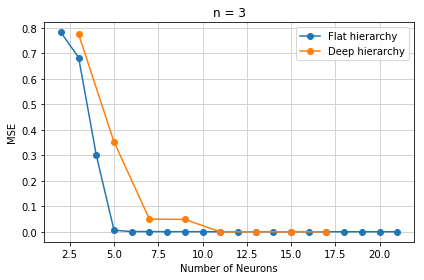

In [2]:
plt.title("n = 3")
plt.xlabel("Number of Neurons")
plt.ylabel("MSE")
plt.grid(color='lightgrey', linestyle='-', linewidth=1)
plt.plot(neurons_flat, minloss_flat, label='Flat hierarchy', marker='o')
plt.plot(neurons_deep, minloss_deep, label='Deep hierarchy', marker='o')
plt.tight_layout()
plt.legend()

#### 3. Interpretiere die Ergenisse für höhere Eingabedimensionen
Nachdem die Neuronenzahl, so gewählt wurde, dass sie Gleichung 5 entspricht, wird der Fehler meist nicht mehr kleiner. Manchmal (z.B. n=4) findet nochmal eine Minimierung statt, wenn man ein Neuron pro Schicht mehr nimmt, als Gleichung 5 angibt.  
Gleichung 5 scheint also zu stimmen.